# Libraries and setup variables

In [14]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,  GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV

from utils import *

%matplotlib inline
sns.set()

### Loading the processed dataset

Here we'll load the data into a dataframe, and run a series of initial exploratory analysis.

We want to scale these features, since otherwise the error calculation might be incorrect as the scales in the various columns change.

In [2]:
X_train = pd.read_csv('../data/processed/X_train.csv')
Y_train = pd.read_csv('../data/processed/Y_train.csv') 
X_test  = pd.read_csv('../data/processed/X_test.csv')
Y_test  = pd.read_csv('../data/processed/Y_test.csv')

In [3]:
# Features needs scaling, as we don't want to be dealing with different magnitudes here.
scaler  = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test  = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

## Class inbalance

Across all the following classifiers we'll be using the 'balanced' option. The class inbalance in the set is quite substantial, hence accuracy alone is meaningless. We'll be using the f1 score instead to measure performance.

### Initial exploration of features importance

We can run a random forest classifier to rank features importance, this should give us an initial first pass.

This model suggests that features such as age or dividends are important in a model. In order to not make the model too complex to start with,
we could take the first 10 or so features first.

In [4]:
names = X_train.columns.values

# Build the model
rfc = RandomForestClassifier(class_weight='balanced')

# Fit the model
rfc.fit(X_train, Y_train)

# Print the results
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), names), reverse=True)[:30])

/Users/lievgarcia/anaconda3/envs/dataiku/lib/python3.6/site-packages/ipykernel/__main__.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Features sorted by their score:
[(0.1361, 'age'), (0.0908, 'weeks worked in year'), (0.08, 'major occupation code_not well-paid occ'), (0.07, 'dividends from stocks'), (0.0563, 'num persons worked for employer'), (0.0541, 'major occupation code_well-paid occ'), (0.0438, 'tax filer stat_Joint both under 65'), (0.0413, 'education_no-college'), (0.0391, 'capital gains'), (0.039, 'family members under 18_Unknown'), (0.0382, 'education_college'), (0.0325, 'detailed household summary in household_Not householder'), (0.0239, 'sex_Male'), (0.0213, 'sex_Female'), (0.0151, 'major industry code_not well-paid ind'), (0.0138, 'own business or self employed'), (0.0127, 'wage per hour'), (0.0127, 'capital losses'), (0.0086, 'detailed household summary in household_Householder'), (0.0078, 'class of worker_Other'), (0.0072, 'class of worker_Private'), (0.0071, 'detailed household and family stat_Householder'), (0.0067, 'detailed household and family stat_Spouse of householder'), (0.006, 'detailed house

In [5]:
# We can also use the SKLearn to select the best features. 
# There are many options for this like Percentile and using f_classification instead of chi2, but this is just a demo for now.

from sklearn.feature_selection import SelectKBest, chi2

best_features = SelectKBest(chi2, k=30).fit(X_train, Y_train.values.ravel())
X_train_best  = best_features.transform(X_train)
X_test_best  = best_features.transform(X_test)

## Dimensionality reduction
We can see from the results above that the dimensionality of this model will be problematic. 

We can use PCA to find the features that most vary across the dataset. We can see that with ~30 features most of the variance is explained.

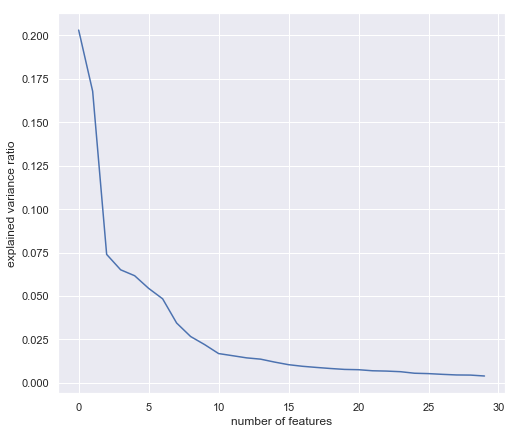

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components= 30)
X_train_PCA = pca.fit_transform(X_train)
X_test_PCA = pca.transform(X_test)

plt.figure(1, figsize=(8, 7))
plt.plot(pca.explained_variance_ratio_)
plt.ylabel('explained variance ratio')
plt.xlabel('number of features')

plt.show()

## Building a couple of classifiers

We'll build a few simple classifiers: Decision Trees, Logistic Regression, Naive Bayes, SVM.

### 1) Decision Tree

Decision tree, achieving over 95% accuracy on both sets. This is better than just predicting everyone does less than 50K, which would be 93% as established in the feature exploration part. At the same time, we should use more advanced measures of accuracy due to the present class inbalance in our population.

In [7]:
random_forest_importance = sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), names), reverse=True)[:30]
important_columns = [f[1] for f in random_forest_importance]

X_train_tree = X_train[important_columns]
X_test_tree  = X_test[important_columns]

clf = DecisionTreeClassifier(max_depth=8) # This depth was adjusted from the next cell results
clf.fit(X_train_tree, Y_train.values.ravel())

Y_train_pred  = clf.predict(X_train_tree)
Y_test_pred  = clf.predict(X_test_tree)

print('Training accuracy: {} %'.format(accuracy_score(Y_train, Y_train_pred)))
print('Test accuracy: {} %'.format(accuracy_score(Y_test, Y_test_pred)))

Training accuracy: 0.95305303148008 %
Test accuracy: 0.9516248671838977 %


#### Overfitting

We can create a few trees with different depths, and we can observe that somehow the trees are very similar once the class_weight is set to balanced. If this was left untouched, then at around depth exceeds 8, we'd start overfitting.

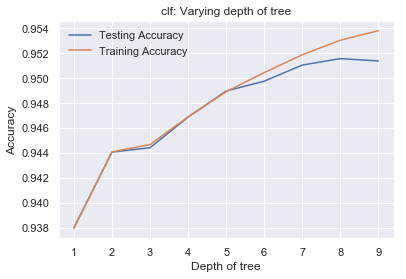

In [8]:
dep = np.arange(1, 10)
train_accuracy = np.empty(len(dep))
test_accuracy = np.empty(len(dep))

for i, k in enumerate(dep):
    
    clf = DecisionTreeClassifier(max_depth=k)
    clf.fit(X_train_tree, Y_train.values.ravel())

    #Compute accuracies
    train_accuracy[i] = clf.score(X_train_tree, Y_train.values.ravel())
    test_accuracy[i] = clf.score(X_test_tree, Y_test.values.ravel())

plt.title('clf: Varying depth of tree')
plt.plot(dep, test_accuracy, label = 'Testing Accuracy')
plt.plot(dep, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.show()

## Dealing with class inbalance

We have fit a Decision Tree classifier to our set. But if we see the performance, while accuracy will be high overall, this is rather meaningless. 
**We need to look at how the smaller class is being classified, depending on the problem at hand this might be important or not**

In [9]:
class_report(Y_test, Y_test_pred,'training')

training Set:

training Confusion Matrix:
[[92797   779]
 [ 4047  2139]]
training Classification report:
             precision    recall  f1-score   support

          0       0.96      0.99      0.97     93576
          1       0.73      0.35      0.47      6186

avg / total       0.94      0.95      0.94     99762

training Accuracy: 0.9516248671838977


**But if we run another classifier with a weighting on the smaller class we observe different results**

Now our performance on the bigger class has decreased, but in the smaller class increased substantially.

## 1) Decision Tree

training Set:

training Confusion Matrix:
[[92796   780]
 [ 4049  2137]]
training Classification report:
             precision    recall  f1-score   support

          0       0.96      0.99      0.97     93576
          1       0.73      0.35      0.47      6186

avg / total       0.94      0.95      0.94     99762

training Accuracy: 0.9515947956135603


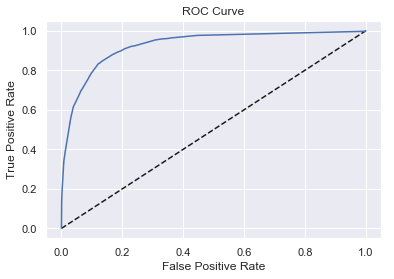

Area under the curve 0.9261976554598061


In [10]:
clf = DecisionTreeClassifier(max_depth=8) # This depth was adjusted from the next cell results
clf.fit(X_train_tree, Y_train.values.ravel())

Y_train_pred  = clf.predict(X_train_tree)
Y_test_pred  = clf.predict(X_test_tree)
class_report(Y_test, Y_test_pred,'training')

# Compute predicted probabilities: y_pred_prob
Y_pred_prob = clf.predict_proba(X_test_tree)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Area under the curve {}'.format(roc_auc))

### 2) Logistic Regression

training Set:

training Confusion Matrix:
[[92813   763]
 [ 4269  1917]]
training Classification report:
             precision    recall  f1-score   support

          0       0.96      0.99      0.97     93576
          1       0.72      0.31      0.43      6186

avg / total       0.94      0.95      0.94     99762

training Accuracy: 0.949559952687396


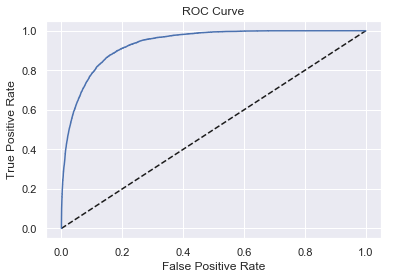

Area under the curve 0.9343300342070295


In [11]:
clf = LogisticRegression()
clf.fit(X_train_tree, Y_train.values.ravel())

Y_train_pred  = clf.predict(X_train_tree)
Y_test_pred  = clf.predict(X_test_tree)
class_report(Y_test, Y_test_pred,'training')

# Compute predicted probabilities: y_pred_prob
Y_pred_prob = clf.predict_proba(X_test_tree)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Area under the curve {}'.format(roc_auc))

## 3) Naive Bayes

training Set:

training Confusion Matrix:
[[78567 15009]
 [ 1044  5142]]
training Classification report:
             precision    recall  f1-score   support

          0       0.99      0.84      0.91     93576
          1       0.26      0.83      0.39      6186

avg / total       0.94      0.84      0.88     99762

training Accuracy: 0.8390870271245564


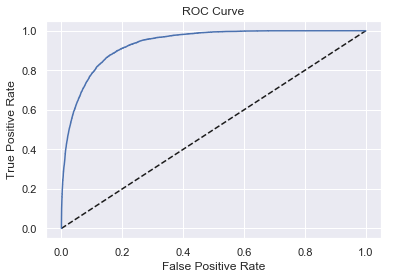

Area under the curve 0.9343300342070295


In [12]:
clf = GaussianNB()

# Train the model using the training sets 
clf.fit(X_train_tree, Y_train.values.ravel())

#Predict Output 
Y_train_pred  = clf.predict(X_train_tree)
Y_test_pred  = clf.predict(X_test_tree)

class_report(Y_test, Y_test_pred,'training')

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Area under the curve {}'.format(roc_auc))

## 4) Gradient Boosting

training Set:

training Confusion Matrix:
[[92613   963]
 [ 3691  2495]]
training Classification report:
             precision    recall  f1-score   support

          0       0.96      0.99      0.98     93576
          1       0.72      0.40      0.52      6186

avg / total       0.95      0.95      0.95     99762

training Accuracy: 0.9533489705499087


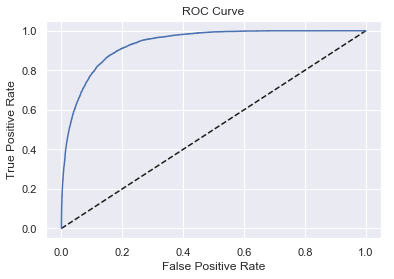

Area under the curve 0.9343300342070295


In [16]:
clf = GradientBoostingClassifier()
clf.fit(X_train_tree, Y_train.values.ravel())

#Predict Output 
Y_train_pred  = clf.predict(X_train_tree)
Y_test_pred  = clf.predict(X_test_tree)

class_report(Y_test, Y_test_pred,'training')

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Area under the curve {}'.format(roc_auc))

## 5) AdaBoost

training Set:

training Confusion Matrix:
[[92665   911]
 [ 3920  2266]]
training Classification report:
             precision    recall  f1-score   support

          0       0.96      0.99      0.97     93576
          1       0.71      0.37      0.48      6186

avg / total       0.94      0.95      0.94     99762

training Accuracy: 0.951574747900002


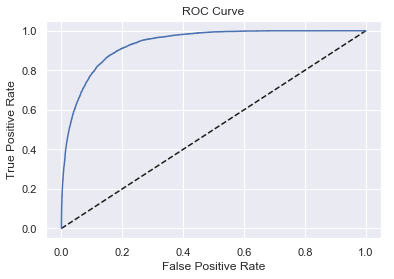

Area under the curve 0.9343300342070295


In [17]:
clf = AdaBoostClassifier()
clf.fit(X_train_tree, Y_train.values.ravel())

#Predict Output 
Y_train_pred  = clf.predict(X_train_tree)
Y_test_pred  = clf.predict(X_test_tree)

class_report(Y_test, Y_test_pred,'training')

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Area under the curve {}'.format(roc_auc))

In [18]:
important_columns

['age',
 'weeks worked in year',
 'major occupation code_not well-paid occ',
 'dividends from stocks',
 'num persons worked for employer',
 'major occupation code_well-paid occ',
 'tax filer stat_Joint both under 65',
 'education_no-college',
 'capital gains',
 'family members under 18_Unknown',
 'education_college',
 'detailed household summary in household_Not householder',
 'sex_Male',
 'sex_Female',
 'major industry code_not well-paid ind',
 'own business or self employed',
 'wage per hour',
 'capital losses',
 'detailed household summary in household_Householder',
 'class of worker_Other',
 'class of worker_Private',
 'detailed household and family stat_Householder',
 'detailed household and family stat_Spouse of householder',
 'detailed household and family stat_Other',
 'race_White',
 'full or part time employment stat_Full-time',
 'country of birth father_United-States',
 'major industry code_well-paid ind',
 'marital stat_not married',
 'country of birth mother_United-States']